In [2]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.pipeline import Pipeline
from pyspark.sql import SparkSession, functions
from pyspark.sql.types import DoubleType

In [3]:
spark = SparkSession \
    .builder \
    .appName("Tabular_Classification") \
    .master("local[*]") \
    .getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


# Simple multiclass classification using Decision Tree
- data: covtype.data.gz

In [10]:
df_without_header = spark.read.\
                    option("inferSchema", True).\
                    option("header", True).\
                    csv("covtype.data.gz")

In [11]:
colNames = ["Elevation",
            "Aspect",
            "Slope",
            "Horizontal_Distance_To_Hydrology",
            "Vertical_Distance_To_Hydrology",
            "Horizontal_Distance_To_Roadways",
            "Hillshade_9am",
            "Hillshade_Noon",
            "Hillshade_3pm",
            "Horizontal_Distance_To_Fire_Points"
           ] + \
            list(map(lambda x: f"Wilderness_Area_{x}", range(0,4))) + \
            list(map(lambda x: f"Soil_Type_{x}", range(0,40))) + \
          ['Cover_Type']

In [12]:
df_with_header = df_without_header.toDF(*colNames)
df_with_header = df_with_header.withColumn("Cover_Type", df_with_header["Cover_Type"].cast(DoubleType()))

In [13]:
df_with_header.printSchema()

root
 |-- Elevation: integer (nullable = true)
 |-- Aspect: integer (nullable = true)
 |-- Slope: integer (nullable = true)
 |-- Horizontal_Distance_To_Hydrology: integer (nullable = true)
 |-- Vertical_Distance_To_Hydrology: integer (nullable = true)
 |-- Horizontal_Distance_To_Roadways: integer (nullable = true)
 |-- Hillshade_9am: integer (nullable = true)
 |-- Hillshade_Noon: integer (nullable = true)
 |-- Hillshade_3pm: integer (nullable = true)
 |-- Horizontal_Distance_To_Fire_Points: integer (nullable = true)
 |-- Wilderness_Area_0: integer (nullable = true)
 |-- Wilderness_Area_1: integer (nullable = true)
 |-- Wilderness_Area_2: integer (nullable = true)
 |-- Wilderness_Area_3: integer (nullable = true)
 |-- Soil_Type_0: integer (nullable = true)
 |-- Soil_Type_1: integer (nullable = true)
 |-- Soil_Type_2: integer (nullable = true)
 |-- Soil_Type_3: integer (nullable = true)
 |-- Soil_Type_4: integer (nullable = true)
 |-- Soil_Type_5: integer (nullable = true)
 |-- Soil_Type

In [ ]:
df_with_header.

In [15]:
train_data, test_data = df_with_header.randomSplit([0.8, 0.2])

In [16]:
# to Persistent layer
train_data.cache()
test_data.cache()

DataFrame[Elevation: int, Aspect: int, Slope: int, Horizontal_Distance_To_Hydrology: int, Vertical_Distance_To_Hydrology: int, Horizontal_Distance_To_Roadways: int, Hillshade_9am: int, Hillshade_Noon: int, Hillshade_3pm: int, Horizontal_Distance_To_Fire_Points: int, Wilderness_Area_0: int, Wilderness_Area_1: int, Wilderness_Area_2: int, Wilderness_Area_3: int, Soil_Type_0: int, Soil_Type_1: int, Soil_Type_2: int, Soil_Type_3: int, Soil_Type_4: int, Soil_Type_5: int, Soil_Type_6: int, Soil_Type_7: int, Soil_Type_8: int, Soil_Type_9: int, Soil_Type_10: int, Soil_Type_11: int, Soil_Type_12: int, Soil_Type_13: int, Soil_Type_14: int, Soil_Type_15: int, Soil_Type_16: int, Soil_Type_17: int, Soil_Type_18: int, Soil_Type_19: int, Soil_Type_20: int, Soil_Type_21: int, Soil_Type_22: int, Soil_Type_23: int, Soil_Type_24: int, Soil_Type_25: int, Soil_Type_26: int, Soil_Type_27: int, Soil_Type_28: int, Soil_Type_29: int, Soil_Type_30: int, Soil_Type_31: int, Soil_Type_32: int, Soil_Type_33: int, S

In [17]:
input_cols = list(filter(lambda x: x!= 'Cover_Type', train_data.columns))
assembler = VectorAssembler(inputCols=input_cols, outputCol="featureVector")
assembled_train_data = assembler.transform(train_data)

In [19]:
# 54 columns to 1 feature vector
# feature vector: SparseVector -> size 54, index, value (save memory storage)
assembled_train_data.select("featureVector").show(5, truncate=False)

+----------------------------------------------------------------------------------------------------+
|featureVector                                                                                       |
+----------------------------------------------------------------------------------------------------+
|(54,[0,1,2,3,4,5,6,7,8,9,13,15],[1860.0,18.0,13.0,95.0,15.0,90.0,210.0,213.0,138.0,780.0,1.0,1.0])  |
|(54,[0,1,2,3,4,5,6,7,8,9,13,15],[1863.0,37.0,17.0,120.0,18.0,90.0,217.0,202.0,115.0,769.0,1.0,1.0]) |
|(54,[0,1,2,3,4,5,6,7,8,9,13,15],[1866.0,23.0,14.0,85.0,16.0,108.0,212.0,210.0,133.0,819.0,1.0,1.0]) |
|(54,[0,1,2,3,4,5,6,7,8,9,13,15],[1867.0,20.0,15.0,108.0,19.0,120.0,208.0,206.0,132.0,808.0,1.0,1.0])|
|(54,[0,1,2,3,4,5,6,7,8,9,13,15],[1868.0,27.0,16.0,67.0,17.0,95.0,212.0,204.0,125.0,859.0,1.0,1.0])  |
+----------------------------------------------------------------------------------------------------+
only showing top 5 rows



## Decision Tree

In [20]:
from pyspark.ml.classification import DecisionTreeClassifier # Estimator
from pyspark.ml.classification import DecisionTreeClassificationModel # Transformer

In [21]:
options = {
    "featuresCol": "featureVector",
    "labelCol": "Cover_Type",
    "predictionCol": "prediction",
    "seed": 530
}

In [22]:
cls = DecisionTreeClassifier(**options)

In [23]:
cls_model = cls.fit(assembled_train_data) # Estimator

In [24]:
print(cls_model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_bf370939790d, depth=5, numNodes=49, numClasses=8, numFeatures=54
  If (feature 0 <= 3052.5)
   If (feature 0 <= 2560.5)
    If (feature 10 <= 0.5)
     If (feature 0 <= 2453.5)
      If (feature 3 <= 15.0)
       Predict: 4.0
      Else (feature 3 > 15.0)
       Predict: 3.0
     Else (feature 0 > 2453.5)
      If (feature 17 <= 0.5)
       Predict: 2.0
      Else (feature 17 > 0.5)
       Predict: 3.0
    Else (feature 10 > 0.5)
     If (feature 9 <= 5201.0)
      Predict: 2.0
     Else (feature 9 > 5201.0)
      If (feature 5 <= 559.0)
       Predict: 2.0
      Else (feature 5 > 559.0)
       Predict: 5.0
   Else (feature 0 > 2560.5)
    If (feature 0 <= 2956.5)
     If (feature 15 <= 0.5)
      If (feature 17 <= 0.5)
       Predict: 2.0
      Else (feature 17 > 0.5)
       Predict: 3.0
     Else (feature 15 > 0.5)
      Predict: 3.0
    Else (feature 0 > 2956.5)
     If (feature 3 <= 214.0)
      If (feature 36 <= 0.5)
    

In [26]:
for score, input_col in sorted(zip(cls_model.featureImportances.toArray(), input_cols), reverse=True):
    if score > 0:
        print(f"{input_col}, {score}")

Elevation, 0.7945114316995494
Horizontal_Distance_To_Hydrology, 0.04023462379843429
Wilderness_Area_0, 0.03063223289248709
Soil_Type_3, 0.03006434590424242
Soil_Type_31, 0.02808012550667735
Hillshade_Noon, 0.02487564306697456
Soil_Type_1, 0.023913238959257815
Wilderness_Area_2, 0.011614419934834608
Soil_Type_22, 0.0064170074811056455
Horizontal_Distance_To_Roadways, 0.006241419011911037
Hillshade_9am, 0.0025857879167668226
Horizontal_Distance_To_Fire_Points, 0.0008297238277591244


In [27]:
predictions = cls_model.transform(assembled_train_data) # Transformer
predictions.select("Cover_Type", "prediction", "probability").show(5, truncate=False)

+----------+----------+------------------------------------------------------------------------------------------------+
|Cover_Type|prediction|probability                                                                                     |
+----------+----------+------------------------------------------------------------------------------------------------+
|3.0       |3.0       |[0.0,0.0,0.034712388533813004,0.6296452217842244,0.05155191549619197,0.0,0.2840904741857706,0.0]|
|6.0       |3.0       |[0.0,0.0,0.034712388533813004,0.6296452217842244,0.05155191549619197,0.0,0.2840904741857706,0.0]|
|3.0       |3.0       |[0.0,0.0,0.034712388533813004,0.6296452217842244,0.05155191549619197,0.0,0.2840904741857706,0.0]|
|3.0       |3.0       |[0.0,0.0,0.034712388533813004,0.6296452217842244,0.05155191549619197,0.0,0.2840904741857706,0.0]|
|3.0       |3.0       |[0.0,0.0,0.034712388533813004,0.6296452217842244,0.05155191549619197,0.0,0.2840904741857706,0.0]|
+----------+----------+---------

# Model Evaluation

In [28]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [29]:
options = {
    'labelCol': 'Cover_Type',
    'predictionCol': 'prediction'
}

In [30]:
evaluator = MulticlassClassificationEvaluator(**options)

In [32]:
print(evaluator.setMetricName("accuracy").evaluate(predictions))
print(evaluator.setMetricName("f1").evaluate(predictions))
print(evaluator.setMetricName("weightedPrecision").evaluate(predictions))
print(evaluator.setMetricName("weightedRecall").evaluate(predictions))

0.7005864402624465


0.6815959089159483


0.6784296249871975


0.7005864402624465


In [33]:
# Confusion Matrix -> Only available at RDD API
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(i, j, format(int(cm[i][j]), fmt),
                 horizontalalignment="center")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

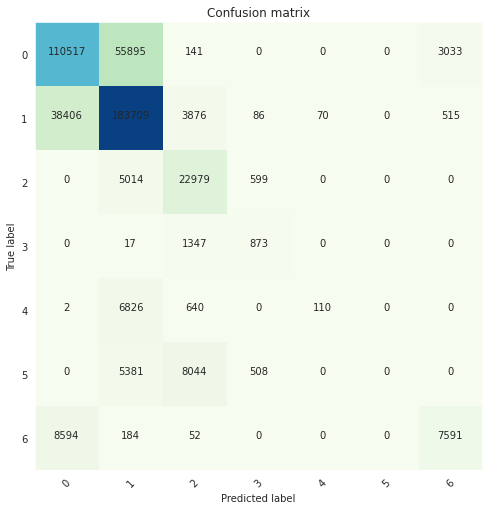

In [95]:
prediction_rdd = predictions.select(["prediction", "Cover_Type"]).rdd
multiclass_metric = MulticlassMetrics(prediction_rdd)
confusion_matrix = multiclass_metric.confusionMatrix().toArray()
confusion_matrix = pd.DataFrame(confusion_matrix)

%matplotlib inline
sns.set_style("darkgrid")
plt.figure(figsize=(7,7))
plt.grid(False)
plot_confusion_matrix(confusion_matrix, classes=range(7))

# Tuning With Pipeline

In [96]:
import time
from pyspark.ml import Pipeline 
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

In [97]:
cls_options = {
    "featuresCol": "featureVector",
    "labelCol": "Cover_Type",
    "predictionCol": "prediction",
    "seed": 530
}

evaluator_options = {
    'labelCol': 'Cover_Type',
    'predictionCol': 'prediction',
    'metricName': 'accuracy'
}


In [98]:
input_cols = list(filter(lambda x: x!= 'Cover_Type', train_data.columns))
assembler = VectorAssembler(inputCols=input_cols, outputCol="featureVector")
cls = DecisionTreeClassifier(**cls_options)
pipeline = Pipeline(stages=[assembler, cls])

param_grid = ParamGridBuilder().\
        addGrid(cls.impurity, ["gini", "entropy"]).\
        addGrid(cls.maxDepth, [1, 20]).\
        addGrid(cls.maxBins, [40, 300]).\
        addGrid(cls.minInfoGain, [0.0, 0.05]).\
        build()
multiclass_evaluator = MulticlassClassificationEvaluator(**evaluator_options)

In [99]:
validation_options = {
    'estimator': pipeline,
    'evaluator': multiclass_evaluator,
    'estimatorParamMaps': param_grid,
    'trainRatio': 0.8,
    'parallelism': 1,
    'seed': 530,
}

In [102]:
# Build Pipeline
start = time.time()
validator = TrainValidationSplit(**validation_options)
validator_model = validator.fit(train_data)
print(f"time elapsed: {time.time() - start}")

21/10/20 14:19:18 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1233.6 KiB
21/10/20 14:19:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1627.8 KiB
21/10/20 14:19:20 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB
21/10/20 14:19:22 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
21/10/20 14:19:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
21/10/20 14:19:25 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.9 MiB
21/10/20 14:19:26 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.6 MiB
21/10/20 14:19:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
21/10/20 14:19:52 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task bi

time elapsed: 280.9802768230438


# Find Best Model

In [103]:
validator_model.bestModel

PipelineModel_d92696eac8ae

In [104]:
best_model = validator_model.bestModel
best_model_param = best_model.stages[-1]
best_model_param.extractParamMap()

{Param(parent='DecisionTreeClassifier_1bd0d42dd04d', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='DecisionTreeClassifier_1bd0d42dd04d', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='DecisionTreeClassifier_1bd0d42dd04d', name='featuresCol', doc='features column name.'): 'featureVector',
 Param(parent='DecisionTreeClassifier_1bd0d42dd04d', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'):

In [106]:
zipped = zip(validator_model.validationMetrics, validator_model.getEstimatorParamMaps())
metrics = sorted(zipped, key = lambda t: t[0], reverse=True)

In [110]:
for metric, params in metrics[:5]:
    print(metric)
    print(params)

0.9075192332488073
{Param(parent='DecisionTreeClassifier_1bd0d42dd04d', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'entropy', Param(parent='DecisionTreeClassifier_1bd0d42dd04d', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 20, Param(parent='DecisionTreeClassifier_1bd0d42dd04d', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 40, Param(parent='DecisionTreeClassifier_1bd0d42dd04d', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0}
0.90708943997937
{Param(parent='DecisionTreeClassifier_1bd0d42dd04d', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'entropy', Param(parent='DecisionTreeCl

In [111]:
max(validator_model.validationMetrics)

0.9075192332488073

In [112]:
# predict test data using best model
multiclass_evaluator.evaluate(best_model.transform(test_data))

21/10/20 14:25:05 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.9 MiB
21/10/20 14:25:05 WARN org.apache.spark.sql.catalyst.csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 2596, 51, 3, 258, 0, 510, 221, 232, 148, 6279, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5
 Schema: 2596, 51, 3, 258, 04, 510, 221, 232, 148, 6279, 110, 011, 012, 013, 014, 015, 016, 017, 018, 019, 020, 021, 022, 023, 024, 025, 026, 027, 028, 029, 030, 031, 032, 033, 034, 035, 036, 037, 038, 039, 040, 041, 142, 043, 044, 045, 046, 047, 048, 049, 050, 051, 052, 053, 5
Expected: 04 but found: 0
CSV file: hdfs://cluster-5a97-m/user/root/covtype.data.gz


0.9126135756280064

# Save and Load Models

In [113]:
best_model.write().overwrite().save("dt_best_model")

21/10/20 14:25:19 WARN org.apache.spark.scheduler.TaskSetManager: Stage 1039 contains a task of very large size (1844 KiB). The maximum recommended task size is 1000 KiB.


In [115]:
from pyspark.ml import PipelineModel
PipelineModel.load("dt_best_model")

PipelineModel_d92696eac8ae